# Predictions (soon)
> Infection predictions for European countries.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/diagram2.png

In [1]:
#hide
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#hide
url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
       'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = pd.read_csv(url)
# rename countries
df['Country/Region'] = df['Country/Region'].replace({'Korea, South': 'South Korea'})
df = df[~df['Country/Region'].isin(['Cruise Ship'])]   # Remove Ships
dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]

In [3]:
#hide
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,NaN,Botswana,-22.328500,24.684900,0,0,0,0,0,0,...,0,0,0,0,0,0,3,4,4,4
254,NaN,Burundi,-3.373100,29.918900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,3
255,NaN,Sierra Leone,8.460555,-11.779889,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,2
256,"Bonaire, Sint Eustatius and Saba",Netherlands,12.178400,-68.238500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [4]:
#hide
from datetime import datetime

def days_since(date, first_date, FMT = '%m/%d/%y'):
    date = '0' + date
    first_date = '0' + first_date
    return (datetime.strptime(date, FMT) - datetime.strptime(first_date, FMT)).days
    
days_since('2/17/20', '2/17/19')

365

In [5]:
#hide
def get_first_date(df):
    return df[df.Confirmed_cases > 100].iloc[0].Dates

In [6]:
#hide
def get_data_for_country(full_df, country):
    cutoff = 30
    data_f = full_df[full_df['Country/Region'] == country]
    nb_cases = data_f.values[0][cutoff:].astype(float)
    dates = data_f.columns[cutoff:]
    df_ = pd.DataFrame({'Dates': dates,
                 'Confirmed_cases': nb_cases})
    first_100 = get_first_date(df_)
    df_['days_since_100'] = df_.apply(lambda x: days_since(x['Dates'], first_100), axis=1)
    df_ = df_[df_['days_since_100'] > -1]
    return df_

In [7]:
#hide
df_it = get_data_for_country(df, 'Italy')

df_it.head()

,Dates,Confirmed_cases,days_since_100
6,2/23/20,155.0,0
7,2/24/20,229.0,1
8,2/25/20,322.0,2
9,2/26/20,453.0,3
10,2/27/20,655.0,4


### Logistic model

In [8]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [9]:
#hide
def logistic_model_it(x,c):
    a=5.4
    b=29
    return c/(1+np.exp(-(x-b)/a))

In [10]:
#hide
def fit_model(df, a_0=2, b_0=30, c_0=200000):
    
    x = list(df.iloc[:,2])
    y = list(df.iloc[:,1])
    
    fit = curve_fit(logistic_model,x,y,p0=[a_0,b_0,c_0])
    a,b,c = fit[0]
    
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    
    print(a,b,c,sol)
    
    # Real data
    plt.scatter(x,y,label="Real data",color="red")

    # Predicted logistic curve
    pred_x = list(range(max(x),sol))
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

    return a,b,c,sol

### Italy

In [12]:
#hide
# 5.453527001573393 29.31561908817068 131674.26008704863 100

5.524276292572734 29.532181543640828 133964.48025958423 98


(5.524276292572734, 29.532181543640828, 133964.48025958423, 98)

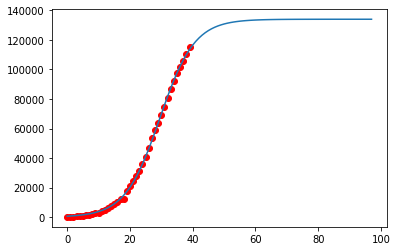

In [13]:
#hide_input
fit_model(df_it)

### Korea

3.9085340515047315 11.790722993272222 9101.804267099998 48


(3.9085340515047315, 11.790722993272222, 9101.804267099998, 48)

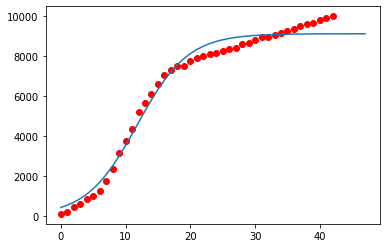

In [14]:
#hide_input
df_k = get_data_for_country(df, 'South Korea')
fit_model(df_k)

### Spain

4.478524154168157 26.2116354626487 148905.86246864035 80


(4.478524154168157, 26.2116354626487, 148905.86246864035, 80)

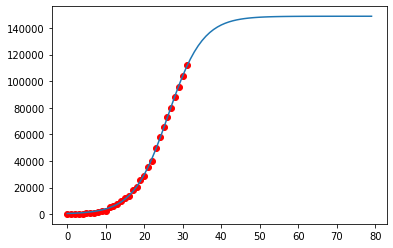

In [15]:
#hide_input
df_lt = get_data_for_country(df, 'Spain')
fit_model(df_lt, a_0=5.4, b_0=29)

### US

3.78741116253639 27.905434288408333 376764.5317700901 78


(3.78741116253639, 27.905434288408333, 376764.5317700901, 78)

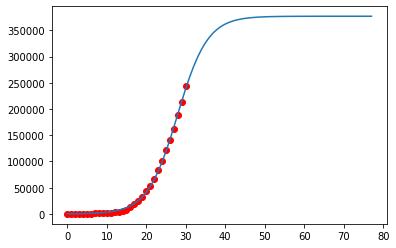

In [16]:
#hide_input
df_lt = get_data_for_country(df, 'US')
fit_model(df_lt, a_0=5.4, b_0=29)

# 3.6019565529706656 27.018334398462475 332232.32656470174 76

### Poland

4.961368762056441 17.930325246415258 5185.287557290507 66


(4.961368762056441, 17.930325246415258, 5185.287557290507, 66)

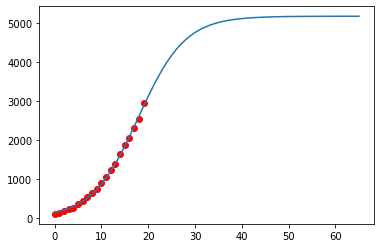

In [17]:
#hide_input
df_lt = get_data_for_country(df, 'Poland')
fit_model(df_lt, a_0=5.4, b_0=29)

# 3.6019565529706656 27.018334398462475 332232.32656470174 76